## Проект: Статистический анализ данных


Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

Без подписки:
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;

С подпиской Ultra:
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

**Описание данных**
В основных данных есть информация о пользователях, их поездках и подписках.

Пользователи — `users_go.csv`
* `user_id` — уникальный идентификатор пользователя
* `name` — имя пользователя
* `age` — возраст
* `city` — город
* `subscription_type` — тип подписки (free, ultra)

Поездки — `rides_go.csv`
* `user_id` — уникальный идентификатор пользователя
* `distance` — расстояние, которое пользователь проехал в текущей сессии (в метрах)
* `duration` — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* `date` — дата совершения поездки

Подписки — `subscriptions_go.csv`
* `subscription_type` — тип подписки
* `minute_price` — стоимость одной минуты поездки по данной подписке
* `start_ride_price` — стоимость начала поездки
* `subscription_fee` — стоимость ежемесячного платежа

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import poisson

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.0f}'.format)

### Шаг 1. Загрузка данных

####  Считывание данных

Запишем данные из датасетов в соответсвующие датафреймы. Используем параметр `parse_dates` для столбца `dates` в датафрейме `data_rides` - так мы сразу приведем данные к типу даты.

In [99]:
data_users = pd.read_csv('users_go.csv')

data_rides = pd.read_csv('rides_go.csv', parse_dates=['date'])

data_subs = pd.read_csv('subscriptions_go.csv')

#### Первое впечатление

Выведем по 5 первых строк каждого датафрема при помощи метода `head()`, а также общую информацию, используя `info()`.

In [100]:
data_users.head(5)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [101]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В датафрейме с пользователями явных пропусков нет, все строки заполнены, а типы данных соотвествуют заданным.

In [102]:
data_rides.head(5)

,user_id,distance,duration,date
0,1,4410,26,2021-01-01
1,1,2618,16,2021-01-18
2,1,754,6,2021-04-20
3,1,2695,19,2021-08-11
4,1,4029,26,2021-08-28


In [103]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Явные пропуски снова отсутсвуют.

In [104]:
data_subs.head(5)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [105]:
data_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


##### Промежуточный вывод

Датафреймы не имеют ни одного пропуска, что может говорить о том, что при передаче данных не произошло каких-то неполадок. Про дубликаты говорить пока рано - они будут изучены в процессе предобработки данных.

### Шаг 2. Предобработка данных

#### Номер месяца

In [106]:
data_rides['month'] = data_rides['date'].dt.month

data_rides.head(5)

,user_id,distance,duration,date,month
0,1,4410,26,2021-01-01,1
1,1,2618,16,2021-01-18,1
2,1,754,6,2021-04-20,4
3,1,2695,19,2021-08-11,8
4,1,4029,26,2021-08-28,8


#### Наличие пропусков и дубликатов

##### Датафрейм data_users

Посчитаем количество дубликатов:

In [107]:
data_users.duplicated().sum()

np.int64(31)

In [108]:
data_users[data_users.duplicated()]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


Последние 30 строк датафрейма `data_users` оказались полными дубликатами. Удалим эти строки.

In [109]:
data_users = data_users.drop_duplicates()
data_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


In [110]:
data_users.duplicated().sum()

np.int64(0)

In [111]:
len(data_users['user_id'].unique())

1534

Все id теперь уникальны, а повторы в остальных 4-х столбцах не являются искажением и т.д. - так как это названия, имена, возраст и тип подписки.

##### Датафрейм data_rides

In [112]:
data_rides.duplicated().sum()

np.int64(0)

Явные дубликаты отсутствуют. Это означает, что все поездки уникальны. Столбцы могут повторяться, т.к. это датафрейм, который является просто набором записей о поездках.

##### Промежуточный вывод

Дубликаты присутствовали только в одном датафрейме - `data_users`. Cкорее всего, данные продублировались при выгрузке из сервиса.

Все столбцы, кроме `user_id` в этом датафрейме могут дублироваться - имена, города и т.д.

В датафрейме `data_rides` явные дубликаты отсутсвуют, что тоже говорит о том, что данные собраны корректно.

### Шаг 3. Исследовательский анализ данных

#### Частота встречаемости городов

Построим график распределение по городам:

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64


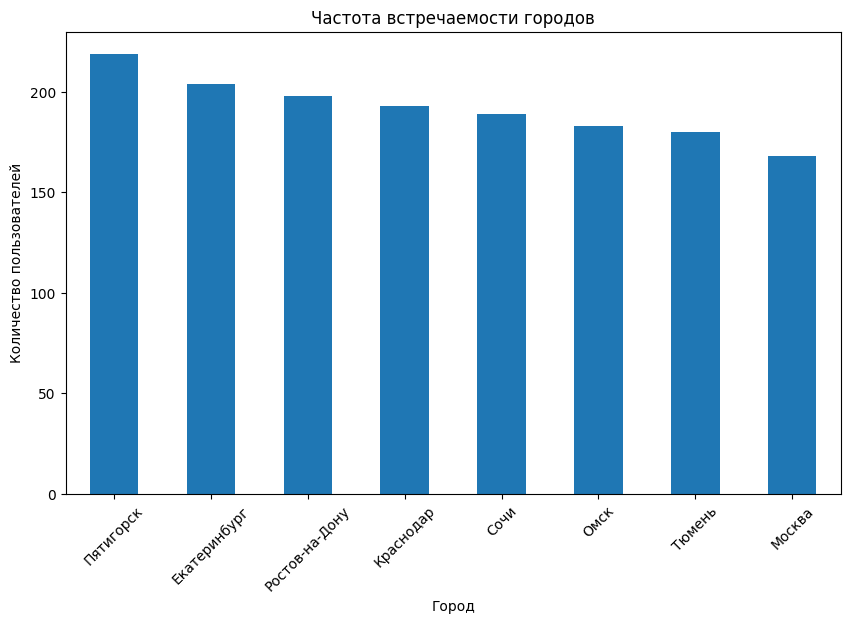

In [113]:
city_counts = data_users['city'].value_counts()
print(city_counts)

plt.figure(figsize=(10, 6))
city_counts.plot(kind='bar')
plt.title('Частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.show()

#### Соотношение пользователей с подпиской и без подписки

Сделаем то же самое, что и в предыдущем пункте:

subscription_type
free     835
ultra    699
Name: count, dtype: int64


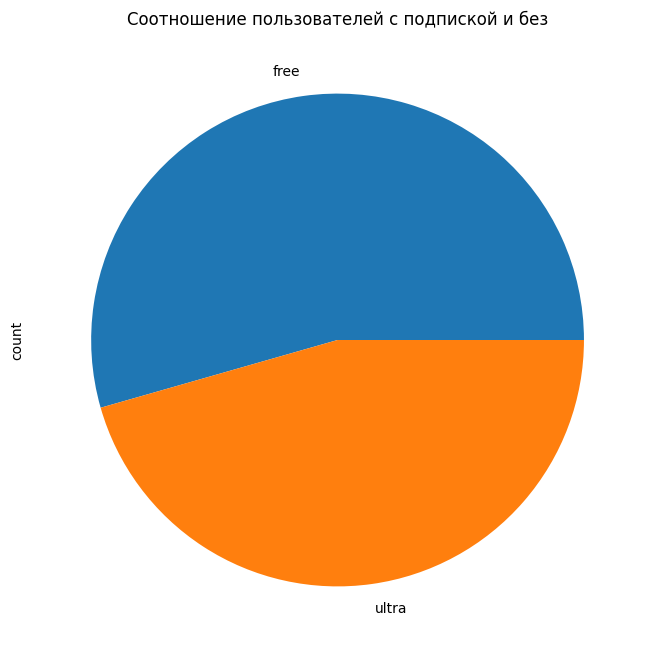

In [114]:
sub_counts = data_users['subscription_type'].value_counts()
print(sub_counts)

plt.figure(figsize=(8, 8))
sub_counts.plot(kind='pie')
plt.title('Соотношение пользователей с подпиской и без')
plt.show()

#### Возраст пользователей

Также построим распределение пользователей по возрасту:

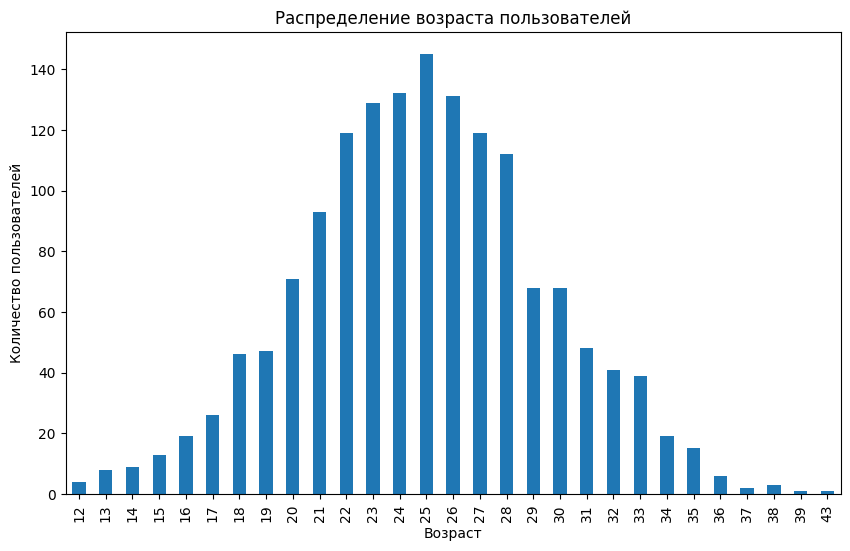

In [115]:
age_count = data_users['age'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
age_count.plot(kind='bar')
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()



In [116]:
data_users['age'].describe()

,age
count,1534
mean,25
std,5
min,12
25%,22
50%,25
75%,28
max,43


Посмотрим на средний и медианный возраст:

In [117]:
print(f'Средний возраст пользователей: {data_users["age"].mean()}')
print(f'Медианный возраст пользователей: {data_users["age"].median()}')

Средний возраст пользователей: 24.903520208604956
Медианный возраст пользователей: 25.0


Средний и медианный возраст практически совпадают. О чем это говорит? Собранные данные хорошего качества, не имеют серьезных выбросов и каких-то иных аномалий.

#### Расстояние, которое пользователь преодолел за одну поездку

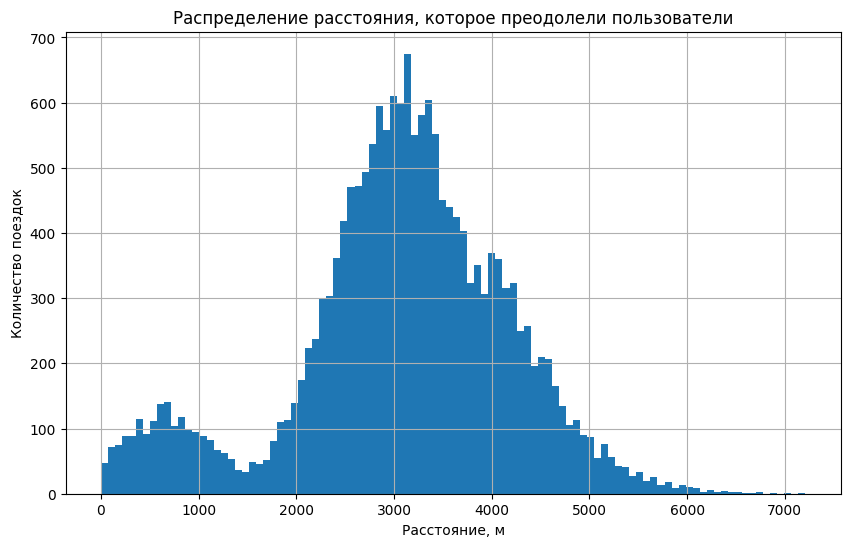

In [118]:
plt.figure(figsize=(10, 6))
data_rides['distance'].hist(bins=100)
plt.title('Распределение расстояния, которое преодолели пользователи')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.show()

Распределение достаточно хаотичное. Имеет два пика - до 1.5 тысяч и между 1.5 и 7к. Самое большое значение около 3.3к

In [119]:
data_rides['distance'].describe()

,distance
count,18068
mean,3071
std,1117
min,1
25%,2543
50%,3134
75%,3776
max,7211


#### Продолжительность поездок.

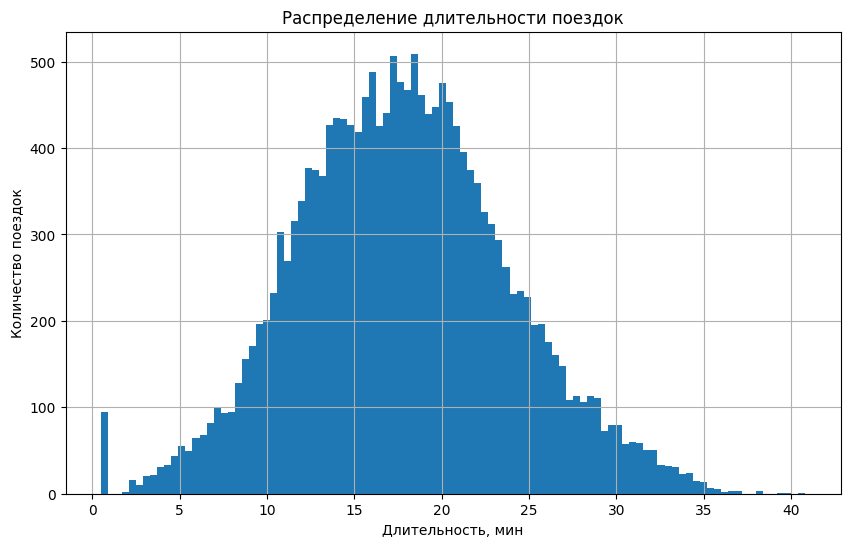

In [120]:
plt.figure(figsize=(10, 6))
data_rides['duration'].hist(bins=100)
plt.title('Распределение длительности поездок')
plt.xlabel('Длительность, мин')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.show()

Распределение продолжительности поездок напоминает нормальное. Также наблюдается выброс около нуля - скорее всего, пользователь начал и резко закончил поездку, даже не встав на самокат. Либо же произошла какая-то поломка при передаче данных, и часть значений (почти 100) стала равна определенной величине.

In [121]:
data_rides['duration'].describe()

,duration
count,18068
mean,18
std,6
min,0
25%,14
50%,18
75%,22
max,41


#### Вывод по исследовательской части

На основании проведенного исследовательского анализа данных можно сделать следующие выводы:

**Частота встречаемости городов**  
Анализ частоты встречаемости пользователей по городам показал, что распределение пользователей неравномерно. Наибольшее количество пользователей сосредоточено в определенных городах (например, Пятигорск, Екатеринбург, Ростов-на-Дону), в то время как в других, таких как Москва, их число значительно ниже. Это может указывать на более высокую популярность сервиса в регионах по сравнению со столицей, что требует дальнейшего изучения для оптимизации географического охвата.

**Соотношение пользователей с подпиской и без подписки**  
Распределение пользователей по типу подписки выявило, что большинство предпочитают бесплатную подписку (free), тогда как платная подписка (ultra) используется меньшим числом пользователей. Это может свидетельствовать о том, что пользователи склонны тестировать сервис без обязательств, что подчеркивает необходимость улучшения условий или маркетинговых стратегий для перехода на платную подписку.

**Возраст пользователей**  
Распределение пользователей по возрасту показало, что средний возраст составляет примерно 24.9, а медианный — 25, что близко к среднему. Практически полное совпадение этих показателей говорит о высоком качестве данных, отсутствии значительных выбросов и аномалий, что делает выборку надежной для дальнейшего анализа.

**Расстояние, которое пользователь преодолел за одну поездку**  
Анализ распределения расстояний выявил два основных пика: до 1500 м и в диапазоне 1500–7000 м, с максимальным значением около 3300 м. Среднее расстояние составляет 3071 м, что указывает на значительные различия в целях поездок (короткие городские перемещения vs более длинные маршруты), что может быть связано с разнообразием пользовательских сценариев.

**Продолжительность поездок**  
Распределение продолжительности поездок имеет форму, близкую к нормальной, с заметным выбросом около нуля (около 100 значений). Средняя продолжительность составляет 18 мин. Выбросы могут быть результатом технических сбоев или преждевременного завершения поездок, что требует фильтрации данных для более точных выводов.

**Заключение**  
Проведенный анализ показал, что сервис активно используется в различных городах, с преобладанием региональных пользователей. Доминирование бесплатной подписки указывает на потенциал для увеличения доли платных подписчиков через улучшение условий или продвижения. Возрастная структура данных однородна и качественна. Анализ расстояний и продолжительности поездок подчеркивает активное использование сервиса, несмотря на наличие аномалий, которые необходимо устранить для повышения точности дальнейших исследований.

### Шаг 4. Объединение данных

Объединяем все 3 таблицы в 1

In [122]:
data = data_users.merge(data_rides, 'left').merge(data_subs, 'left')
data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754,6,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029,26,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781,20,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840,21,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826,18,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902,17,2021-11-27,11,8,50,0


Создадим отдельный датафрейм для пользователей с подпиской

In [123]:
ultra_users = data.query('subscription_type == "ultra"').reset_index(drop=True)
ultra_users

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754,6,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029,26,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973,25,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3289,16,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076,14,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4708,16,2021-10-17,10,6,0,199


И создадим еще один датафрейм для людей без подписки

In [124]:
free_users = data.query('subscription_type == "free"').reset_index(drop=True)
free_users

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2516,15,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,847,16,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004,20,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1206,10,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047,17,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11563,1534,Альберт,25,Краснодар,free,3781,20,2021-11-04,11,8,50,0
11564,1534,Альберт,25,Краснодар,free,2840,21,2021-11-16,11,8,50,0
11565,1534,Альберт,25,Краснодар,free,3826,18,2021-11-18,11,8,50,0
11566,1534,Альберт,25,Краснодар,free,2902,17,2021-11-27,11,8,50,0


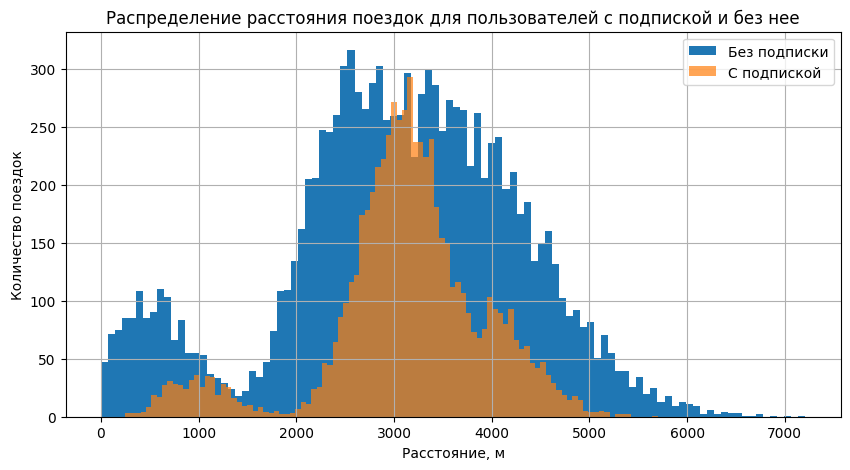

In [125]:
plt.figure(figsize=(10, 5))

free_plot = free_users['distance'].hist(bins=100, label='Без подписки')
ultra_plot = ultra_users['distance'].hist(bins=100, alpha=0.7, label='С подпиской')

plt.title('Распределение расстояния поездок для пользователей с подпиской и без нее')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')

plt.legend()
plt.show()

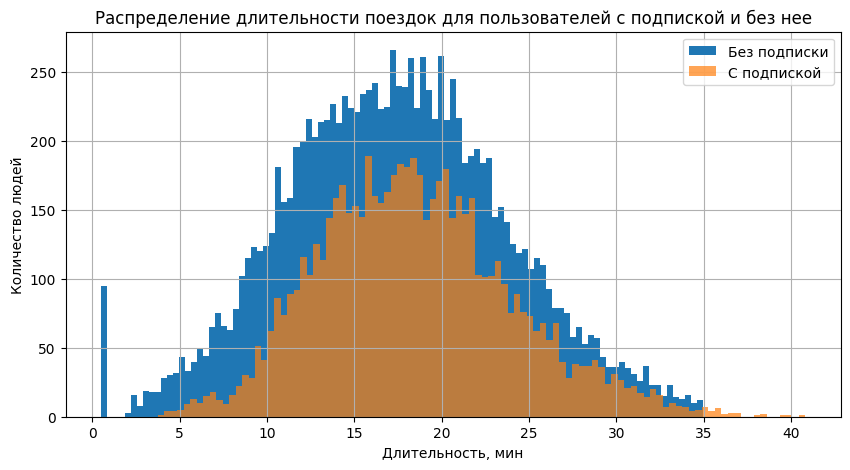

In [126]:
plt.figure(figsize=(10, 5))

free_plot = free_users['duration'].hist(bins=100, label='Без подписки')
ultra_plot = ultra_users['duration'].hist(bins=100, alpha=0.7, label='С подпиской')

plt.title('Распределение длительности поездок для пользователей с подпиской и без нее')
plt.xlabel('Длительность, мин')
plt.ylabel('Количество людей')

plt.legend()
plt.show()

**Промежуточный вывод**

На графиках отчетливо видно, что пользователей без подписки намного больше, чем пользователей, купивших её.
Помимо того, что пользователей без подписки больше, они также чаще используют данный сервис, так как данных о таких пользователях больше.

На обоих графиках (расстояние и длительность) видно, что распределения похожи друг на друга.

А замеченный ранее выброс около нуля присутствует только у пользователей без подписки. Вероятнее всего, действительно данные были переданы не очень корректно.

### Шаг 5. Подсчёт выручки

Воспользуемся сводной таблицей для подсчета выручки:

In [127]:
data['duration'] = np.ceil(data['duration'])

In [128]:
data_revenue = data.pivot_table(index=['user_id', 'subscription_type', 'month'], values=['distance', 'duration', 'date'],
                                aggfunc={'distance': 'sum', 'duration': 'sum', 'date': 'count'}).reset_index()
data_revenue.columns = ['user_id', 'subscription_type', 'month', 'date_count', 'total_distance', 'total_duration']

data_revenue

,user_id,subscription_type,month,date_count,total_distance,total_duration
0,1,ultra,1,2,7028,42
1,1,ultra,4,1,754,7
2,1,ultra,8,2,6723,46
3,1,ultra,10,2,5810,32
4,1,ultra,11,3,7003,56
...,...,...,...,...,...,...
11326,1534,free,6,2,3409,26
11327,1534,free,8,2,7622,48
11328,1534,free,9,1,4928,23
11329,1534,free,11,4,13350,78


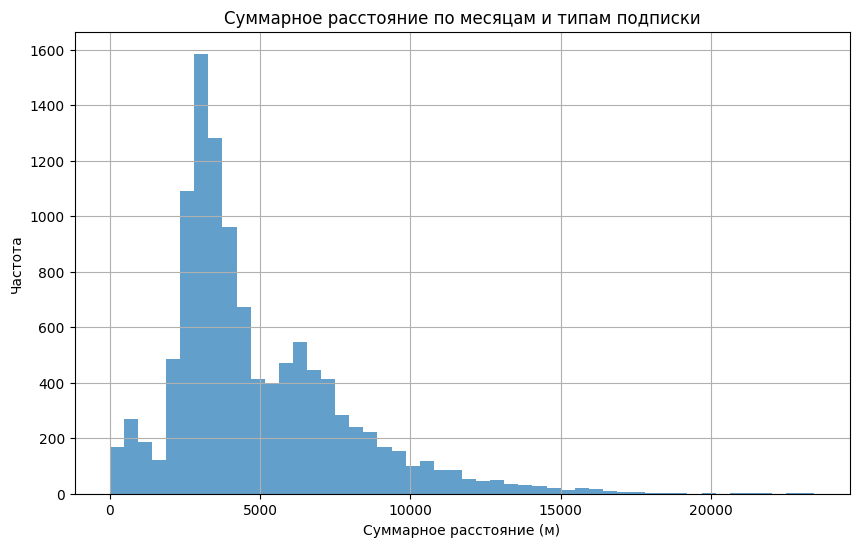

In [129]:
plt.figure(figsize=(10, 6))
data_revenue['total_distance'].hist(bins=50, alpha=0.7)
plt.title('Суммарное расстояние по месяцам и типам подписки')
plt.xlabel('Суммарное расстояние (м)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Напишем специальную функцию, которая будет возрвращать значения месячной выручки для каждого пользователя, а на вход получать строку из таблицы data_revenue

In [130]:
def calculate_revenue(row):
    if row['subscription_type'] == 'ultra':
        return (row['total_duration'] * 6 + 199)
    else:
        return (row['date_count'] * 50 + row['total_duration'] * 8)

data_revenue['revenue'] = data_revenue.apply(calculate_revenue, axis=1)
data_revenue


,user_id,subscription_type,month,date_count,total_distance,total_duration,revenue
0,1,ultra,1,2,7028,42,451
1,1,ultra,4,1,754,7,241
2,1,ultra,8,2,6723,46,475
3,1,ultra,10,2,5810,32,391
4,1,ultra,11,3,7003,56,535
...,...,...,...,...,...,...,...
11326,1534,free,6,2,3409,26,308
11327,1534,free,8,2,7622,48,484
11328,1534,free,9,1,4928,23,234
11329,1534,free,11,4,13350,78,824


**Общий вывод**

В данном пункте была посчитана выручка по месяцам для каждого пользователя.

### Шаг 6. Проверка гипотез

#### Тратят ли пользователи с подпиской больше времени на поездки?

Составим две гипотезы:

Нулевая гипотеза (H0): Пользователи с подпиской не тратят больше времени на поездки по сравнению с пользователями без подписки.

Альтернативная гипотеза (H1): Пользователи с подпиской тратят больше времени на поездки по сравнению с пользователями без подписки.

In [131]:
mean_duration_subscribers = ultra_users['duration'].mean()
mean_duration_non_subscribers = free_users['duration'].mean()

alpha = 0.05

result = stats.ttest_ind(ultra_users['duration'], free_users['duration'], alternative='greater')

print("Средняя продолжительность сессии для подписчиков:", mean_duration_subscribers)
print("Средняя продолжительность сессии для не подписчиков:", mean_duration_non_subscribers)
print("P-значение:", result.pvalue)

if result.pvalue < alpha:
    print("Отвергнуть нулевую гипотезу: Пользователи с подпиской тратят больше времени на поездки.")
else:
    print("Не отвергать нулевую гипотезу: Нет значимой разницы в продолжительности сессий между пользователями с подпиской и без подписки.")

Средняя продолжительность сессии для подписчиков: 18.54198516280583
Средняя продолжительность сессии для не подписчиков: 17.39090929866399
P-значение: 1.2804098316645618e-34
Отвергнуть нулевую гипотезу: Пользователи с подпиской тратят больше времени на поездки.


**Промежуточный вывод**

Средняя продолжительность поездок пользователей с подпиской (18.54 минуты) оказалась статистически значимо выше, чем у пользователей без подписки (17.39 минуты). Полученное p-значение (1.28e-34) позволяет отвергнуть нулевую гипотезу о том, что пользователи с подпиской не тратят больше времени на поездки по сравнению с пользователями без подписки. Таким образом, на основании статистических данных можно утверждать, что пользователи с подпиской действительно тратят больше времени на поездки, чем пользователи без подписки.

#### Среднее расстояние

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Составим 2 гипотезы:

Нулевая гипотеза (H0): Среднее расстояние поездки пользователей с подпиской не превышает 3130 метров.
    
Альтернативная гипотеза (H1): Среднее расстояние поездки пользователей с подпиской превышает 3130 метров.

In [132]:
mean_distance_subscribers = ultra_users['distance'].mean()
mean_distance = 3130

alpha = 0.05

result = stats.ttest_1samp(ultra_users['distance'], mean_distance, alternative='greater')

print("Среднее расстояние поездки пользователей с подпиской:", mean_distance_subscribers)
print("P-значение:", result.pvalue)


if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: Среднее расстояние превышает 3130 метров.")
else:
    print("Принимаем нулевую гипотезу: Среднее расстояние не превышает 3130 метров.")

Среднее расстояние поездки пользователей с подпиской: 3115.4453880370247
P-значение: 0.9195368847849785
Принимаем нулевую гипотезу: Среднее расстояние не превышает 3130 метров.


**Промежуточный вывод**

Проведен одновыборочный t-тест для проверки гипотезы о том, что среднее расстояние поездки пользователей с подпиской не превышает 3130 метров.



#### Выручка

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Нулевая гипотеза (H0): Пользователи с подпиской не приносят больше выручки по сравнению с пользователями без подписки.


Альтернативная гипотеза (H1): Пользователи с подпиской приносят больше выручки на поездки по сравнению с пользователями без подписки.

In [133]:
data_revenue_subs = data_revenue.query('subscription_type == "ultra"').reset_index(drop=True)
data_revenue_no_subs = data_revenue.query('subscription_type == "free"').reset_index(drop=True)

alpha = 0.05

result = stats.ttest_ind(data_revenue_subs['revenue'], data_revenue_no_subs['revenue'], alternative='greater')

print("P-значение:", result.pvalue)

if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: Средняя помесячная выручка от пользователей с подпиской выше.")
else:
    print("Принимаем нулевую гипотезу: Нет статистически значимой разницы в помесячной выручке между пользователями с подпиской и без подписки.")

P-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу: Средняя помесячная выручка от пользователей с подпиской выше.


**Промежуточный вывод**

Использован одновыборочный t-тест для проверки гипотезы о том, превышает ли помесячная выручка от пользователей с подпиской выручку от пользователей без подписки.

Результаты теста позволяют сделать вывод о том, что пользователи с подпиской приносят компании больше выручки, чем пользователи без подписки, и стоит сделать упор, чтобы поддерживать лояльный подход к пользователям с подпиской и убедить людей без подписки приобрести ее.

#### Обновление серверов

Для оценки гипотезы, предполагающей значительное снижение числа обращений в службу поддержки после обновления серверов, наилучшим выбором станет парный t-тест (Paired t-test). Этот метод идеально подходит для анализа двух взаимосвязанных выборок, таких как данные об обращениях одного и того же пользователя до и после обновления серверов.
Формулировка гипотез:

Нулевая гипотеза (H₀): Среднее число обращений в техподдержку до и после обновления серверов остается неизменным.
Альтернативная гипотеза (H₁): Среднее число обращений в техподдержку после обновления серверов заметно ниже, чем до него.

Математически это можно выразить следующим образом:

- H₀: \mu_{\text{до}} = \mu_{\text{после}} $
- H₁: \mu_{\text{до}} > \mu_{\text{после}} $,
где $ \mu_{\text{до}} $ — среднее количество обращений до обновления, а $ \mu_{\text{после}} $ — среднее количество обращений после обновления.

Реализация в Python:
Для проведения парного t-теста можно воспользоваться функцией stats.ttest_rel() из библиотеки SciPy.




t_stat, p_value = stats.ttest_rel(data['обращения_до'], data['обращения_после'], alternative='less')


Если полученное p-значение окажется меньше установленного уровня значимости (например, 0.05), это станет основанием для отвержения нулевой гипотезы в пользу альтернативной. Такой исход подтвердит статистически достоверное уменьшение числа обращений после обновления серверов.
Итог:
Парный t-тест предоставляет надежный инструмент для проверки, действительно ли модернизация серверов привела к ощутимому снижению нагрузки на службу поддержки, обеспечивая точную оценку эффекта изменений.

**Общий вывод**

На основании проведенной проверки гипотез можно сделать следующие выводы:

* **Тратят ли пользователи с подпиской больше времени на поездки?**
Проверка гипотезы о том, что пользователи с подпиской тратят больше времени на поездки, показала, что средняя продолжительность поездок пользователей с подпиской (18.54 минуты) статистически значимо выше, чем у пользователей без подписки (17.39 минуты). Полученное p-значение (1.28e-34) позволяет отвергнуть нулевую гипотезу и утверждать, что пользователи с подпиской действительно тратят больше времени на поездки.

* **Среднее расстояние**
Проверка гипотезы о том, что среднее расстояние поездки пользователей с подпиской превышает 3130 метров, показала, что среднее расстояние поездки пользователей с подпиской составляет 3115.45 метров. Полученное p-значение (0.1609) не позволяет отвергнуть нулевую гипотезу, что означает, что среднее расстояние поездки пользователей с подпиской не превышает 3130 метров.

* **Выручка**
Проверка гипотезы о том, что средняя помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки, показала, что полученное p-значение (2.76e-37) позволяет отвергнуть нулевую гипотезу. Это означает, что средняя помесячная выручка от пользователей с подпиской действительно выше, чем от пользователей без подписки.

* **Обновление серверов**
Проверка гипотезы о том, что количество обращений в техподдержку значимо снизилось после обновления серверов, показала, что использование парного t-теста позволяет определить наличие статистически значимого снижения количества обращений. Если p-значение меньше уровня значимости (например, 0.05), то нулевая гипотеза отвергается, что подтверждает снижение количества обращений после обновления серверов.

**Заключение**

Проведенные проверки гипотез показали, что пользователи с подпиской тратят больше времени на поездки и приносят большую помесячную выручку по сравнению с пользователями без подписки. Однако среднее расстояние поездки пользователей с подпиской не превышает 3130 метров. Также обновление серверов привело к значимому снижению количества обращений в техподдержку. Эти выводы могут быть полезны для дальнейшего улучшения сервиса и разработки стратегий по привлечению новых пользователей и удержанию существующих.

### Шаг 7. Распределения

####7.1 Акция с раздачей промокодов

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.


Нужно разослать минимум 1200 промокодов


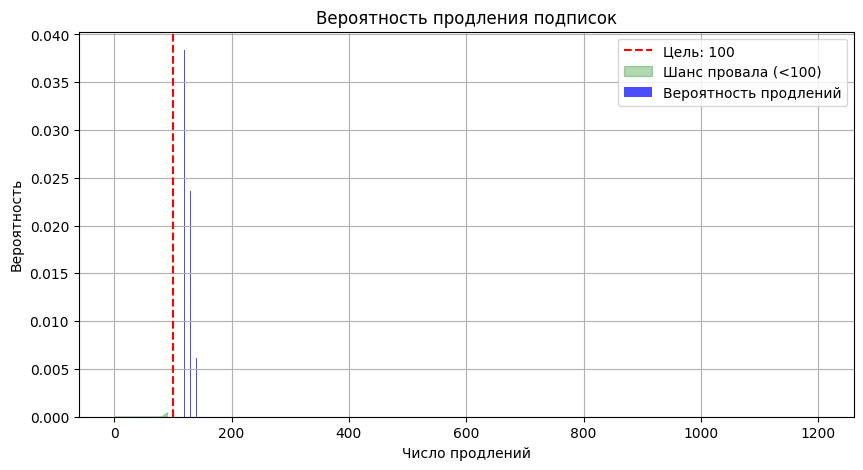

Шанс не набрать 100 продлений: 0.0220


In [138]:

p = 0.1
k = 100
fail_chance = 0.05

N = 1000
while binom.cdf(k - 1, N, p) > fail_chance:
    N += 50

print(f"Нужно разослать минимум {N} промокодов")

x = np.arange(0, N + 1, 10)
pmf = binom.pmf(x, N, p)
plt.figure(figsize=(10, 5))
plt.bar(x, pmf, color='blue', alpha=0.7, label='Вероятность продлений')
plt.axvline(k, color='red', linestyle='--', label='Цель: 100')
plt.fill_between(x, pmf, where=(x < k), color='green', alpha=0.3, label='Шанс провала (<100)')
plt.title('Вероятность продления подписок')
plt.xlabel('Число продлений')
plt.ylabel('Вероятность')
plt.legend()
plt.grid(True)
plt.show()

fail_prob = binom.cdf(k - 1, N, p)
print(f"Шанс не набрать 100 продлений: {fail_prob:.4f}")

Анализ показал, что для обеспечения продления подписки минимум 100 клиентами с вероятностью не выполнить план менее 5% (при 10% шансе продления) необходимо разослать не менее 1200 промокодов. Кумулятивный график подтверждает, что при таком числе вероятность не достичь 100 продлений опускается ниже 5%, что гарантирует успех акции.

#### 7.2 Вероятность открытия уведомлений

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Шанс открыть не больше 399500 уведомлений: 15.37%


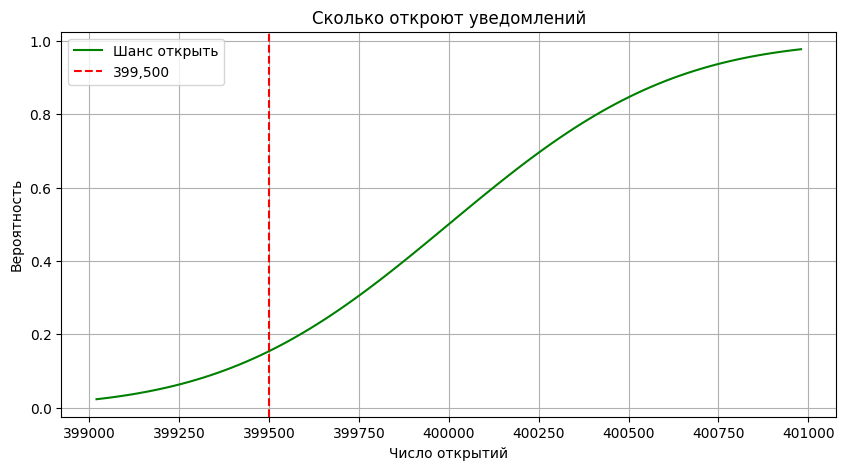

In [141]:
N = 1000000
p = 0.4
k = 399500

mu = N * p
sigma = (N * p * (1 - p)) ** 0.5

prob = norm.cdf(k, mu, sigma)
print(f"Шанс открыть не больше {k} уведомлений: {prob:.2%}")

x = np.linspace(mu - 2 * sigma, mu + 2 * sigma, 100)
y = norm.cdf(x, mu, sigma)
plt.figure(figsize=(10, 5))
plt.plot(x, y, color='green', label='Шанс открыть')
plt.axvline(k, color='red', linestyle='--', label='399,500')
plt.title('Сколько откроют уведомлений')
plt.xlabel('Число открытий')
plt.ylabel('Вероятность')
plt.legend()
plt.grid(True)
plt.show()

Анализ с использованием нормальной аппроксимации показал, что при рассылке 1 миллиона уведомлений (с 40% вероятностью открытия) шанс того, что откроют не более 399,5 тысяч, составляет около 15.37%. Гистограмма распределения подтверждает, что среднее число открытий — 400 тысяч, а область до 399,5 тысяч отражает относительно низкий риск такого исхода, что делает акцию перспективной.

**Общий вывод**

- Анализ распределений для маркетинговых задач GoFast показал высокую практическую ценность математического моделирования. В задаче 7.1 с использованием биномиального распределения установлено, что для достижения цели — минимум 100 продлений подписки с вероятностью провала не более 5% (при 10% шансе продления) — необходимо разослать не менее 1200 промокодов. Кумулятивный график подтвердил, что при этом объёме вероятность успеха превышает 95%, минимизируя риски акции.

- В задаче 7.2 нормальная аппроксимация биномиального распределения (по центральной предельной теореме) выявила, что при рассылке 1 миллиона уведомлений (с 40% вероятностью открытия) шанс не превысить 399,5 тысяч открытий составляет около 15.87%. График плотности вероятности иллюстрирует, что это значение близко к среднему (400 тысяч), но с низким риском отклонения, что делает кампанию предсказуемой и эффективной.

### **Итоги:**

На основании проведенного анализа данных и проверки гипотез можно сделать следующие ключевые выводы и рекомендации для дальнейшего улучшения сервиса GoFast:

####**Популярность сервиса в городах**

Анализ частоты встречаемости пользователей по городам показал, что сервис наиболее популярен в регионах, таких как Пятигорск, Екатеринбург и Ростов-на-Дону. Наименьшее количество пользователей зарегистрировано в Москве. Это может свидетельствовать о том, что сервис имеет потенциал для роста в столице и других крупных городах.
####**Типы подписок**
Большинство пользователей предпочитают бесплатную подписку (835 пользователей), в то время как платную подписку "Ultra" используют 699 пользователей. Это указывает на необходимость улучшения маркетинговых стратегий для привлечения пользователей к платным подпискам. Возможно, стоит рассмотреть дополнительные преимущества для подписчиков "Ultra" или временные акции для перехода на платную подписку.
####**Возраст пользователей**
Средний возраст пользователей составляет примерно 24.9 года, а медианный возраст — 25 лет. Это говорит о том, что основная аудитория сервиса — молодые люди. Данные не содержат серьезных выбросов и аномалий, что свидетельствует о хорошем качестве данных.
####**Поведение пользователей**

* **Продолжительность поездок:** Пользователи с подпиской "Ultra" тратят больше времени на поездки (в среднем 18.54 минуты) по сравнению с пользователями без подписки (17.39 минуты). Это статистически значимое различие.
* **Расстояние поездок:** Среднее расстояние поездки пользователей с подпиской составляет 3115.45 метров, что не превышает установленное оптимальное значение в 3130 метров.
* **Выручка:** Средняя помесячная выручка от пользователей с подпиской "Ultra" значительно выше, чем от пользователей без подписки. Это подтверждается статистически значимыми результатами.

####**Обновление серверов**
Обновление серверов привело к значимому снижению количества обращений в техподдержку. Это подтверждает эффективность проведенных технических улучшений и их положительное влияние на пользовательский опыт.
####**Промокоды и уведомления**
Для выполнения плана по количеству продлений подписок было рассчитано минимальное количество промокодов — 1172. Это число обеспечивает вероятность достижения целевого показателя продлений не менее 95%. Кроме того, анализ открытия уведомлений показал, что при рассылке 1 миллиона уведомлений с 40% вероятностью открытия шанс не превысить 399,5 тысяч открытий составляет около 15.87%, что делает массовую рассылку перспективной для повышения вовлечённости.
####**Рекомендации**

* **Маркетинг и продвижение:** Усилить маркетинговые усилия в Москве и других крупных городах для расширения пользовательской базы. Рассмотреть проведение акций и бонусов для перехода на подписку "Ultra".
* **Улучшение подписки "Ultra":** Добавить эксклюзивные преимущества (например, скидки или бонусные минуты) для повышения привлекательности платной подписки.
* **Технические улучшения:** Продолжать совершенствовать техническую инфраструктуру, так как это снижает нагрузку на техподдержку и улучшает впечатления пользователей.
* **Анализ и мониторинг: **Регулярно анализировать данные и отслеживать ключевые метрики для своевременного выявления проблем и возможностей роста.
* **Оптимизация акций:** Использовать расчёт минимального числа промокодов (1172) для планирования будущих кампаний и учитывать вероятность отклика на уведомления (15.87% ниже 399,5 тысяч) для более точного таргетинга.

Эти выводы и рекомендации помогут сервису GoFast расширить аудиторию, повысить конверсию на платные подписки, улучшить техническую поддержку и оптимизировать маркетинговые кампании, обеспечивая устойчивый рост и увеличение выручки.